# hw 5: kernel density estimation (KDE)

In [4]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Random
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"
using Printf

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib.rcParams)                           
rcParams["font.size"] = 16

# use PyCall to call in Seaborn
using PyCall
# using Seaborn
seaborn = pyimport("seaborn")

# note: some have done the following to bring `kdeplot` and `rugplot` into the namespace
#  but I recommend the above. you need to install Seaborn, the Python package.
# using Seaborn

PyObject <module 'seaborn' from '/Users/siddharthganesh/.julia/conda/3/lib/python3.7/site-packages/seaborn/__init__.py'>

## data on forest fires in the northeast region of Portugal

(1) read in `forestfires.csv` as a `DataFrame`. [source](https://archive.ics.uci.edu/ml/datasets/Forest+Fires)

* each row corresponds to the occurance of a forest fire. 
* the `:temp` attribute is the temperature in Celsius degrees when the forest fire occurred
* the `:RH` attribute is the relative humidity in % when the forest fire occurred

In [5]:
df = CSV.read("forestfires.csv")
first(df, 5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH
,Int64,Int64,String,String,Float64,Float64,Float64,Float64,Float64,Int64
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99


## using Seaborn to do KDE

(2) use Seaborn's [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) function and [rugplot](https://seaborn.pydata.org/generated/seaborn.rugplot.html) function to, on the same plot, draw a rugplot and 1D KDE of the temperature during forest fires in Portugal.

* shade in the area under the curve (see `shade` in the documentation)
* use the cosine kernel, denoted as `"cos"` in Seaborn (see `kernel` in the documentation) the cosine kernel has finite, compact support, unlike the Gaussian kernel
* label the x, y-axes with appropriate units (note: both have units!)

note regarding translation of Seaborn (Python) documentation to Julia: keep in mind that we need to pass strings `kernel="gau"` in Julia as opposed to `kernel='gau'` which works in Python.

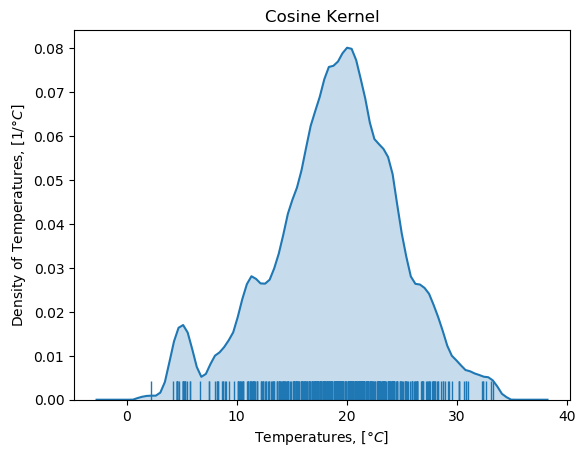

PyObject Text(0.5, 1, 'Cosine Kernel')

In [296]:
seaborn.kdeplot(df[:, :temp], kernel = "cos", shade = true)
seaborn.rugplot(df[:, :temp])
xlabel(L"Temperatures, [$°C$]")
ylabel(L"Density of Temperatures, [$1/°C$]")
title("Cosine Kernel")

(3) draw a scatter plot to visualize the relationship, during forest fires, between:
* x-axis: temperature
* y-axis: relative humidity

label the x- and y-axes along with units.

use green "+" markers.

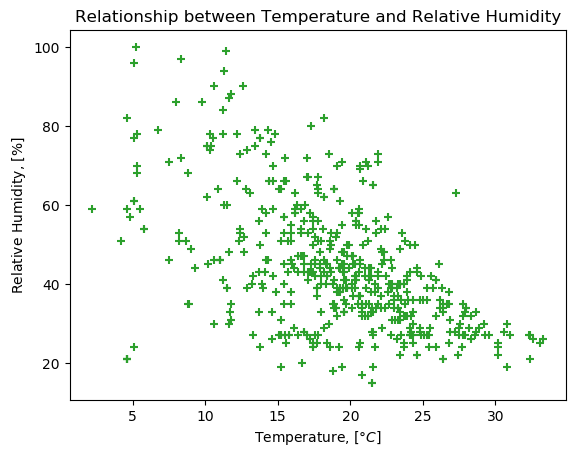

PyObject Text(0.5, 1, 'Relationship between Temperature and Relative Humidity')

In [298]:
figure()
scatter(df[:, :temp], df[:, :RH], marker = "+", c = "C2")
xlabel(L"Temperature, [$°C$]")
ylabel(L"Relative Humidity, [$\%$]")
title("Relationship between Temperature and Relative Humidity")

(4) now draw a bivariate KDE using Seaborn's [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) function that corresponds to your scatter plot in (3).
* devote the x-axis to temperature
* devote the y-axis to relative humidity
* label the x, y- axes with units
* pass `shade=true` to shade between the contours
* pass `shade_lowest=false` to avoid shading regions of temperature-relative humidity space where forest fires were very unlikely to occur.
* pass `cmap="Greens"` to change the colormap to use green colors for the shading.

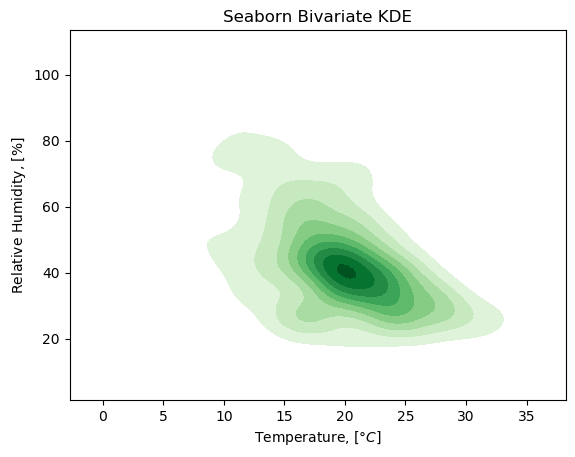

PyObject Text(0.5, 1, 'Seaborn Bivariate KDE')

In [306]:
seaborn.kdeplot(df[:, :temp], df[:, :RH], kernel = "cos",
    shade = true, shade_lowest = false, cmap = "Greens")
xlabel(L"Temperature, [$°C$]")
ylabel(L"Relative Humidity, [$\%$]")
title("Seaborn Bivariate KDE")

## coding up your own 1D top hat KDE
To intimately understand KDE, let's code up own own KDE with a new kernel we haven't seen before, the top hat function, which looks like a top hat. See what the top hat kernel looks like [here](https://scikit-learn.org/stable/_images/sphx_glr_plot_kde_1d_002.png). The top hat function has finite and compact [support](https://en.wikipedia.org/wiki/Support_(mathematics)) and is (piecewise) flat. The top hat kernel is implemented in scikitlearn's kernel density estimate module if you are interesting in checking your code. let $X$ denote the random variable whose density we seek to estimate (via top hat kernel density estimation).

(5) write a function `K_top_hat(x::Float64, x_i::Float64, λ::Float64)` the returns the value of the top hat kernel density at `x` conributed by data point `x_i`. `λ` is the bandwidth of the top hat kernel, which is half of its width. think carefully about what the height should be...

In [300]:
function K_top_hat(x::Float64, x_i::Float64, λ::Float64)
    lower_bandwidth = (x_i - λ)
    upper_bandwidth = (x_i + λ)
    if x <= lower_bandwidth
        return 0.0
    elseif x > upper_bandwidth
        return 0.0
    else
        return 1/(2*λ)
    end
end

K_top_hat (generic function with 1 method)

(6) write a function `top_hat_kde(x::Float64, x_sample::Array{Float64}, λ::Float64)` that takes in the point `x` at which we seek to estimate the density, the array of samples of $x$ (the data and the `x_i`'s for `K_top_hat`) `x_sample`, and the bandwidth `λ` of the top hat kernel used to make the density estimate, then returns the top hat kernel density estimate at `x`.

In [301]:
function top_hat_kde(x::Float64, x_sample::Array{Float64}, λ::Float64)
    density_estimate = 0.0
    for i=1:length(x_sample)
        density_estimate+=K_top_hat(x, x_sample[i], λ)
    end
    return density_estimate/length(x_sample)
end

top_hat_kde (generic function with 1 method)

(7) finally, use your function `top_hat_kde` to estimate the density of temperatures during forest fires in Portugal at a dense span of temperatures ranging from 0 to 50.0. Use a bandwidth of 1.5. plot the density as in question (2) and compare. What strikes you as a qualitative difference between the KDE using top hat vs. cosine kernel in (2)?
***Answer***
The top hat kernel is less smooth compared to cosine kernel. The top hat kernel is also finite.

note: in comparing the scale on the y-axis here and in your plot from question (2) generated with Seaborn, you should get a hint of whether or not you chose the height of the top hat kernel correctly. Remember that the total kernel density should integrate to 1.0.

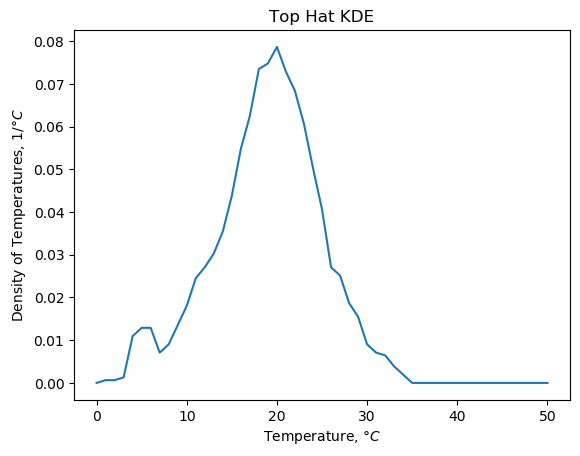

PyObject Text(0.5, 1, 'Top Hat KDE')

In [309]:
temperatures = range(0.0, stop=50.0)
ρ=[top_hat_kde(temp, df[:, :temp], λ) for temp in temperatures]
figure()
plot(temperatures, ρ)
xlabel(L"Temperature, $°C$")
ylabel(L"Density of Temperatures, $1/°C$")
title("Top Hat KDE")

In [303]:
x = 20.0
λ = 1.5
top_hat_kde(x, df[:, :temp], λ)

0.07865892972275954

In [304]:
using ScikitLearn
@sk_import neighbors.kde : KernelDensity
kde = KernelDensity(kernel="tophat", bandwidth=1.5)
sample_temps=[[row[:temp]] for row in eachrow(df)]
kde.fit(sample_temps)
ρ_at_20 = exp.(kde.score_samples([[20.0]]))

1-element Array{Float64,1}:
 0.07736943907156653

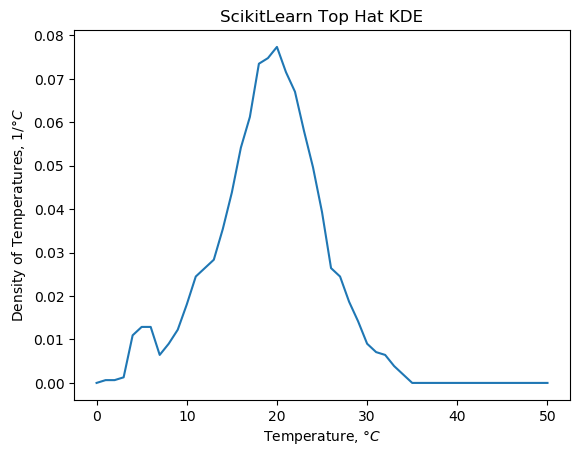

PyObject Text(0.5, 1, 'ScikitLearn Top Hat KDE')

In [308]:
ρ_sci = exp.(kde.score_samples([[temp] for temp in temperatures]))
figure()
plot(temperatures,ρ_sci)
xlabel(L"Temperature, $°C$")
ylabel(L"Density of Temperatures, $1/°C$")
title("ScikitLearn Top Hat KDE")